In [2]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import numpy as np
import pandas as pd

In [3]:
# check if rio exist in the geoboundries

import geopandas as gpd

# Path to the geojson file
boundary_file = r"D:\NU\semester_5\data_analysis\project\edited_project\geoBoundaries-BRA-ADM1-all\geoBoundaries-BRA-ADM1.geojson"

# Load the GeoJSON file
brazil_boundaries = gpd.read_file(boundary_file)

# Inspect the available columns to find the city name column
print(brazil_boundaries.columns)

brazil_boundaries

city_name_column = "shapeName"

rio_boundary = brazil_boundaries[brazil_boundaries[city_name_column] == "Rio de Jeneiro"]

# Check if the boundary is found
if not rio_boundary.empty:
    print("Rio de Janeiro boundary found!")
else:
    raise ValueError("Rio de Janeiro boundary not found. Check the city name or column.")

rio_boundary.to_file("rio_boundary.geojson", driver="GeoJSON")

# Print the coordinates of the boundary (or process further as needed)
print(rio_boundary)

Index(['shapeName', 'shapeISO', 'shapeID', 'shapeGroup', 'shapeType',
       'geometry'],
      dtype='object')
Rio de Janeiro boundary found!
         shapeName shapeISO                  shapeID shapeGroup shapeType  \
22  Rio de Jeneiro    BR-RJ  14911670B85657526756793        BRA      ADM1   

                                             geometry  
22  POLYGON ((-44.78723 -22.42088, -44.78871 -22.4...  


In [13]:
# Filepaths

# raster_file = r"D:\NU\semester_5\data_analysis\project\edited_project\SVDNB_npp_20200101-20200131_00N060W_vcmcfg_v10_c202002111500\SVDNB_npp_20200101-20200131_00N060W_vcmcfg_v10_c202002111500.avg_rade9h.tif"
# raster_file = r"D:\NU\semester_5\data_analysis\project\edited_project\SVDNB_npp_20200201-20200229_00N060W_vcmcfg_v10_c202003021200\SVDNB_npp_20200201-20200229_00N060W_vcmcfg_v10_c202003021200.avg_rade9h.tif"
raster_file = r"D:\NU\semester_5\data_analysis\project\edited_project\SVDNB_npp_20200301-20200331_00N060W_vcmcfg_v10_c202007042300\SVDNB_npp_20200301-20200331_00N060W_vcmcfg_v10_c202007042300.avg_rade9h.tif"

rio_boundary_file = r"D:\NU\semester_5\data_analysis\project\edited_project\rio_boundary.geojson"

# output_csv = r"D:\NU\semester_5\data_analysis\project\edited_project\viirs_rio_1_dataset.csv"
# output_csv = r"D:\NU\semester_5\data_analysis\project\edited_project\viirs_rio_2_dataset.csv"
output_csv = r"D:\NU\semester_5\data_analysis\project\edited_project\viirs_rio_3_dataset.csv"

# Load the Brasília boundary
rio = gpd.read_file(rio_boundary_file)
rio = rio.to_crs(epsg=4326)

# Open the VIIRS raster file
with rasterio.open(raster_file) as src:
    raster_bounds = box(*src.bounds)
    print("Raster Bounds:", src.bounds)
    print("rio Bounds:", rio.total_bounds)

    if not raster_bounds.intersects(rio.unary_union):
        raise ValueError("rio's boundary does not overlap with the raster extent.")

    # Clip the VIIRS raster file
    rio_geom_list = [feature["geometry"] for feature in rio.__geo_interface__["features"]]
    clipped_raster, clipped_transform = mask(src, rio_geom_list, crop=True)

# Extract Raster Values for Brasília
light_intensity = clipped_raster[0]
rows, cols = np.where(~np.isnan(light_intensity))
values = light_intensity[rows, cols]
x_coords, y_coords = rasterio.transform.xy(clipped_transform, rows, cols)

# Create a DataFrame
data = pd.DataFrame({
    'longitude': x_coords,
    'latitude': y_coords,
    'light_intensity': values
})

# Save the data to a CSV file
data.to_csv(output_csv, index=False)
print(f"Extracted data for rio saved to {output_csv}")


Raster Bounds: BoundingBox(left=-60.00208333335, bottom=-64.99791718665, right=59.99791762665001, top=0.00208333335)
rio Bounds: [-44.92543978 -23.44057219 -40.96355631 -20.83745118]


C:\Users\PC\AppData\Local\Temp\ipykernel_17912\1849445727.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  if not raster_bounds.intersects(rio.unary_union):


Extracted data for rio saved to D:\NU\semester_5\data_analysis\project\edited_project\viirs_rio_3_dataset.csv


In [3]:
import pandas as pd

In [4]:
output_csv = r"D:\NU\semester_5\data_analysis\project\edited_project\viirs_rio_1_dataset.csv"

df = pd.read_csv(output_csv)
df.head()

,longitude,latitude,light_intensity
0,-44.925000,-20.8375,0.0
1,-44.920833,-20.8375,0.0
2,-44.916667,-20.8375,0.0
3,-44.912500,-20.8375,0.0
4,-44.908333,-20.8375,0.0


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'light_intensity'}>, <Axes: >]],
      dtype=object)

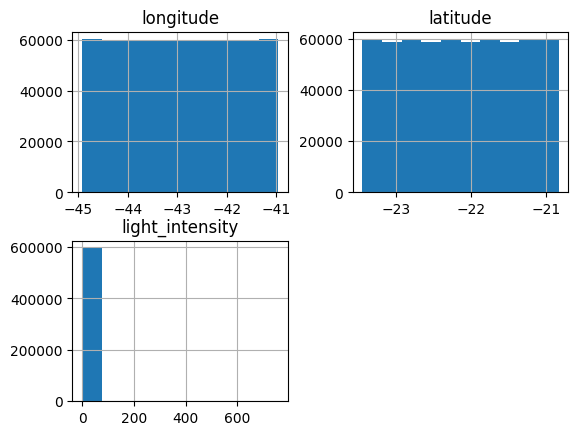

In [11]:
df.hist()
